In [57]:
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso


RANDOM_STATE = 42
TARGET = "SalePrice"
TEST_SIZE = 0.2  # 20% of data reserved for testing

In [58]:
# Define project directories
PROJECT_ROOT = Path("..").resolve()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
REPORTS_DIR = PROJECT_ROOT / "reports"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

In [59]:
# Load dataset
df = pd.read_csv(DATA_RAW / "house_prices_train.csv")

In [60]:
# Separate features and target variable
y = df[TARGET]
X = df.drop(columns=[TARGET])

In [61]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

In [62]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.to_list()
if 'Id' in numeric_cols:
    numeric_cols.remove('Id')
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Categorical columns: {categorical_cols}")
print(f"Numeric columns: {numeric_cols}")

Categorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea'

In [63]:
# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Create the pipeline with preprocessing and regression model
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

In [64]:
# Fit the model
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [66]:
alpha_results = []

alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for alpha in alpha_values:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", Ridge(alpha=alpha)),
        ]
    )
    
    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        return_train_score=False,
    )
    
    rmse_values = -cv_scores["test_score"]

    alpha_result = {
        "alpha_value": alpha,
        "rmse_mean": rmse_values.mean(),
        "rmse_std": rmse_values.std(),
    }

    alpha_results.append(alpha_result)

# Create DataFrame and sort by RMSE mean
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df = alpha_results_df.sort_values(by="rmse_mean")

# Display the best alpha value
best_alpha = alpha_results_df.iloc[0]
print(f"Best alpha: {best_alpha['alpha_value']}, RMSE: {best_alpha['rmse_mean']:.4f}")
alpha_results_df

Best alpha: 10.0, RMSE: 31556.1745


,alpha_value,rmse_mean,rmse_std
4,10.000,31556.174539,7216.615113
5,100.000,32304.774754,7450.226999
3,1.000,32814.497631,7332.537866
2,0.100,35227.911632,7378.296507
6,1000.000,35985.023798,5366.936468
1,0.010,36243.910934,7490.030809
0,0.001,36398.241915,7511.731520


In [67]:
alpha_results_df.to_csv(REPORTS_DIR / "ridge_alpha_search.csv", index=False)


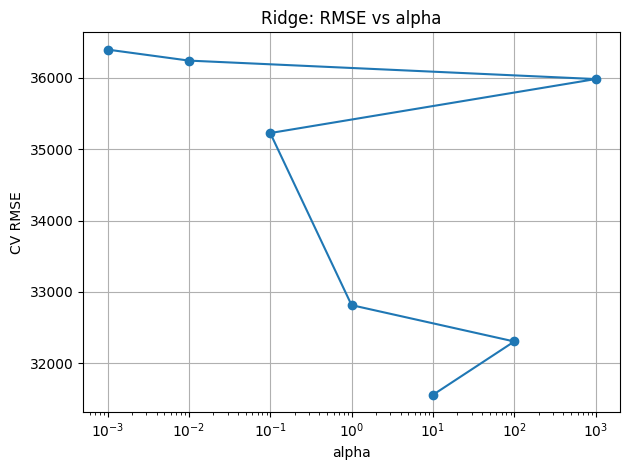

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(alpha_results_df["alpha_value"], alpha_results_df["rmse_mean"], marker="o")
plt.xscale("log")  # because alpha ranges over several orders of magnitude
plt.xlabel("alpha")
plt.ylabel("CV RMSE")
plt.title("Ridge: RMSE vs alpha")
plt.grid(True)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "figures" / "ridge_alpha_curve.png")
